# Binary classification

The main objective of the predictive analysis is to find potential dropout so that support could be extended. This is best done through a binary classifcation.

We label all with Dropout as target as 1 and others as 0. 

**Metric**

We are interested in capturing all the potential dropouts. So the preffered metric to look for would be Recall.

In [33]:
#import libraries

import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder

from sklearn.model_selection import StratifiedShuffleSplit, cross_validate, GridSearchCV, train_test_split

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier

from sklearn.metrics import classification_report, ConfusionMatrixDisplay, recall_score, accuracy_score

from sklearn import set_config

from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.pipeline import Pipeline as imb_pipeline
from imblearn.over_sampling import SMOTENC

In [3]:
train = pd.read_csv("./../data/2_final/train.csv")
test =  pd.read_csv("./../data/2_final/test.csv")

In [4]:
features_to_include = ['Marital status', 'Application mode', 'Application order', 'Course',
       'Attendance_mode', 'Previous qualification (grade)', 'Admission grade', 'Displaced', 
       'Educational special needs', 'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder',
       'Age at enrollment', 'International', 'father_occ', 'mother_occ', 'father_qual', 'mother_qual', 'previous_qual',
        'Target']

In [5]:
train_df = train[features_to_include]
test_df = test[features_to_include]

In [6]:
y_train = train_df["Target"]
X_train = train_df.drop("Target", axis=1)

y_test = test_df["Target"]
X_test = test_df.drop("Target", axis=1)

## Changing labels to binary

In [7]:
y_train = np.where(y_train == 'Dropout', 1, 0)
y_test = np.where(y_test == 'Dropout', 1, 0)


## Preprocessing

In [8]:
cat_features = ['Course', 'previous_qual', 'Debtor', 'Gender', 'Scholarship holder', 'father_occ', 'mother_occ', 'father_qual', 'mother_qual', 'Marital status', 'Application mode', 'Attendance_mode', 'International', 'Displaced']
num_features = ['Previous qualification (grade)', 'Admission grade', 'Age at enrollment', 'Application order']

In [52]:
select_cat_features = ColumnTransformer([('select_cat', 'passthrough', cat_features)])
cat_transformers = Pipeline([('selector', select_cat_features),
                            ('onehot', OneHotEncoder(handle_unknown='ignore')),
                            ])

                            
select_num_features = ColumnTransformer([('select_num', 'passthrough', num_features)])
num_transformers = Pipeline([('selector', select_num_features),
                            ('scaler', StandardScaler()),
                            ])

preprocess_pipe = FeatureUnion([('cat', cat_transformers),
                                ('num', num_transformers),
                                ])

In [53]:
class Model:
    def __init__(self, model_name, estimator, preprocessor=None, scoring=None, cv=5, sampler = None, random_state=42):
        self.name = model_name
        self.estimator = estimator
        self.preprocess = preprocessor
        self.scoring = scoring
        self.cv = cv
        self.rs = random_state
        self.sampler = sampler

    def make_model_pipeline(self):
        if self.sampler == None:
            self.model = Pipeline([('preprocess', self.preprocess),
                                ('model', self.estimator)])
        else:
            self.model = imb_pipeline([('sampler', self.sampler),
                                    ('preprocess', self.preprocess),
                                    ('model', self.estimator)])


    def train(self, X_train, y_train):
        '''Trains the  model
        Args:
            X_train: Training data feature matrix
            y_train: Training data label vector
            
        Returns:
            trained model
        '''
        self.make_model_pipeline()

        
        self.cv_results = cross_validate(self.model, X_train, y_train, cv=self.cv, scoring=self.scoring, return_train_score=True)

        mean_train_score = self.cv_results["train_score"].mean()
        mean_val_score = self.cv_results["test_score"].mean()
        
        std_train_score = self.cv_results["train_score"].std()
        std_val_score = self.cv_results["test_score"].std()

        print(f"Cross validated training results for {self.name} model")
        print("---------------------------------------------------------")
        print(f"Train score: {mean_train_score} +/- {std_train_score}" )
        print(f"Validation score: {mean_val_score} +/- {std_val_score}" )

        self.fitted_model = self.model.fit(X_train, y_train)

    def evaluate(self, X_test, y_test):
        y_pred = self.fitted_model.predict(X_test)

        recall = recall_score(y_test, y_pred)
        acc = accuracy_score(y_test, y_pred)
        print("Recall score on test set: ", recall)
        print("Accuracy score on test set: ", acc)
        print()
        print(classification_report(y_test, y_pred))
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    
    def tune(self, param_grid, X_train, y_train):
        '''Do hyper parameter tuning using GridSearch strategy
        
        Args:
            model: Model to be tuned
            param_grid: dict of parameters
            X_train: Feature matrix
            y_train: Label matrix
            
        Returns: 
            best parameters
            best estimator
        '''

        self.make_model_pipeline()
        search = GridSearchCV(self.model, param_grid = param_grid,
                            cv = self.cv,
                            scoring=self.scoring,
                            return_train_score=True)
        
        search.fit(X_train, y_train)
        
        print("Best parameters: ", search.best_params_)
        
        print("-------------------Best model performance --------------------------")
        
        mean_train_score = search.cv_results_['mean_train_score'][search.best_index_]
        mean_val_score = search.cv_results_['mean_test_score'][search.best_index_]
        std_train_score = search.cv_results_['std_train_score'][search.best_index_]
        std_val_score = search.cv_results_['std_test_score'][search.best_index_]

        print(f"Score of the model on the train set:\n"
            f"{mean_train_score:.3f} +/- {std_train_score:.6f}")

        print(f"Score of the model on the validation set:\n"
            f"{mean_val_score:.3f} +/- {std_val_score:.6f}")
        
        self.fitted_model = search.best_estimator_

In [54]:
##Let's supress sklearn warnings

def warn(*args, **kwargs):
    pass

import warnings
warnings.warn = warn

In [55]:
## Cross validation scheme

cv = StratifiedShuffleSplit(n_splits = 5, test_size=0.2, random_state=32)

### Baseline model

We know that the dropout rate is 32%. The simplest baseline would be one where the 32% of the samples are randomly assigned the label 1.

In [56]:
baseline_clf = Model(model_name="Baseline classifier", 
                    estimator=DummyClassifier(strategy='stratified'),
                    preprocessor=preprocess_pipe,
                    scoring="recall",
                    cv = cv,
                    random_state=32)

In [57]:
baseline_clf.train(X_train, y_train)

Cross validated training results for Baseline classifier model
---------------------------------------------------------
Train score: 0.3336263736263736 +/- 0.010204999354939698
Validation score: 0.32775330396475766 +/- 0.0188142348053415


Recall score on test set:  0.3485915492957746
Accuracy score on test set:  0.5751412429378531

              precision    recall  f1-score   support

           0       0.69      0.68      0.69       601
           1       0.34      0.35      0.34       284

    accuracy                           0.58       885
   macro avg       0.52      0.52      0.52       885
weighted avg       0.58      0.58      0.58       885



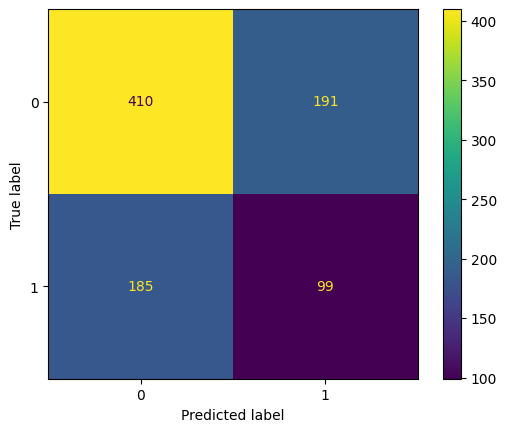

In [58]:
baseline_clf.evaluate(X_test, y_test)

### Logistic Regression

In [62]:
logistic_clf = Model(model_name="Logistic Regression", 
                    estimator=LogisticRegression(penalty = "elasticnet", solver="saga", l1_ratio=0,  max_iter=1000),
                    preprocessor=preprocess_pipe,
                    scoring="recall",
                    cv = cv,
                    random_state=32)

In [63]:
logistic_clf.train(X_train, y_train)

Cross validated training results for Logistic Regression model
---------------------------------------------------------
Train score: 0.48901098901098905 +/- 0.004963336171708236
Validation score: 0.4775330396475771 +/- 0.03660366181117354


In [64]:
param_grid = {"model__C": [0.01, 0.1, 1, 10, 100],
            "model__l1_ratio": np.linspace(0, 1, 11)}
logistic_clf.tune(param_grid, X_train, y_train)

Best parameters:  {'model__C': 10, 'model__l1_ratio': 0.1}
-------------------Best model performance --------------------------
Score of the model on the train set:
0.503 +/- 0.005229
Score of the model on the validation set:
0.488 +/- 0.040317


Recall score on test set:  0.47183098591549294
Accuracy score on test set:  0.7468926553672316

              precision    recall  f1-score   support

           0       0.78      0.88      0.82       601
           1       0.64      0.47      0.54       284

    accuracy                           0.75       885
   macro avg       0.71      0.67      0.68       885
weighted avg       0.74      0.75      0.73       885



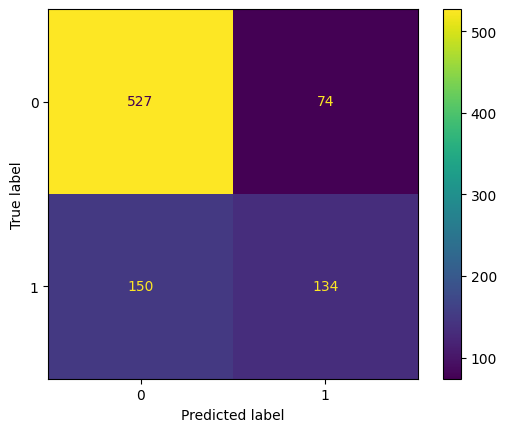

In [65]:
logistic_clf.evaluate(X_test, y_test)

### Ridge classifier

In [66]:
ridge_clf = Model(model_name = "Ridge classifier", 
                    estimator = RidgeClassifier(),
                    preprocessor = preprocess_pipe,
                    scoring = "recall",
                    random_state = 32)

In [67]:
ridge_clf.train(X_train, y_train)

Cross validated training results for Ridge classifier model
---------------------------------------------------------
Train score: 0.46965751520206966 +/- 0.0045767944528367155
Validation score: 0.44591544941649275 +/- 0.021174178085234484


In [68]:
param_grid = {"model__alpha": [0.01, 0.1, 1, 10, 100]}
ridge_clf.tune(param_grid, X_train, y_train)

Best parameters:  {'model__alpha': 0.01}
-------------------Best model performance --------------------------
Score of the model on the train set:
0.471 +/- 0.004295
Score of the model on the validation set:
0.449 +/- 0.023773


Recall score on test set:  0.44366197183098594
Accuracy score on test set:  0.7435028248587571

              precision    recall  f1-score   support

           0       0.77      0.89      0.82       601
           1       0.65      0.44      0.53       284

    accuracy                           0.74       885
   macro avg       0.71      0.66      0.68       885
weighted avg       0.73      0.74      0.73       885



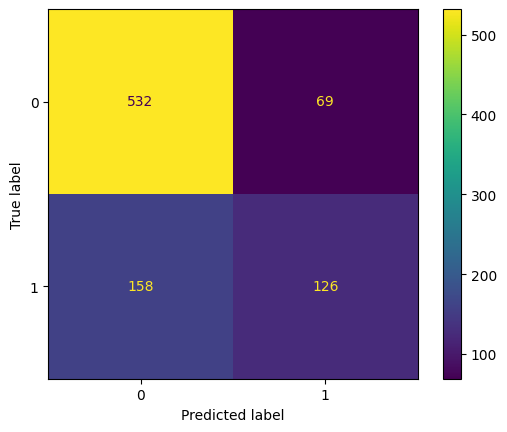

In [69]:
ridge_clf.evaluate(X_test, y_test)

### Support vector machine

In [70]:
svm_clf = Model(model_name = "SVM classifier", 
                    estimator = LinearSVC(loss='hinge'),
                    preprocessor = preprocess_pipe,
                    scoring = "recall",
                    random_state = 32)

In [71]:
svm_clf.train(X_train, y_train)

Cross validated training results for SVM classifier model
---------------------------------------------------------
Train score: 0.4562465697119163 +/- 0.01712010158181091
Validation score: 0.44236417033773867 +/- 0.024304462187390224


In [115]:
param_grid = {"model__penalty": ["l1", "l2"],
                "model__C": [0.1, 1, 10, 100, 150, 200]}
svm_clf.tune(param_grid, X_train, y_train)

Best parameters:  {'model__C': 100, 'model__penalty': 'l2'}
-------------------Best model performance --------------------------
Score of the model on the train set:
0.600 +/- 0.083565
Score of the model on the validation set:
0.564 +/- 0.084690


Recall score on test set:  0.5422535211267606
Accuracy score on test set:  0.6926553672316385

              precision    recall  f1-score   support

           0       0.78      0.76      0.77       601
           1       0.52      0.54      0.53       284

    accuracy                           0.69       885
   macro avg       0.65      0.65      0.65       885
weighted avg       0.70      0.69      0.69       885



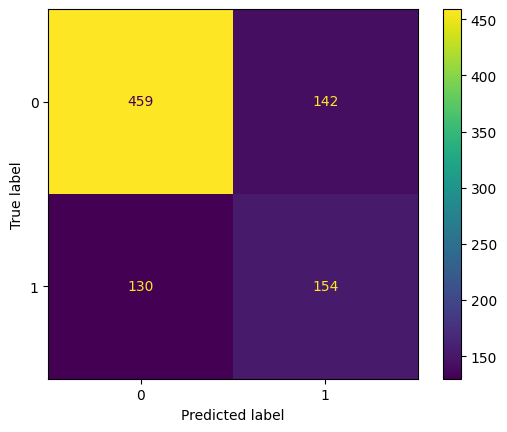

In [116]:
svm_clf.evaluate(X_test, y_test)

### Decision tree 

In [74]:
tree_clf = Model(model_name = "Decision tree classifier", 
                    estimator = DecisionTreeClassifier(),
                    preprocessor = preprocess_pipe,
                    scoring = "recall",
                    random_state = 32)

In [75]:
tree_clf.train(X_train, y_train)

Cross validated training results for Decision tree classifier model
---------------------------------------------------------
Train score: 1.0 +/- 0.0
Validation score: 0.5057307365329624 +/- 0.04257110323517152


In [76]:
param_grid = {"model__max_depth": [2, 3, 4, 5, 10],
                "model__min_samples_split":[2, 4, 6, 8, 10],
                "model__min_samples_leaf": [1, 2, 3, 6, 7, 8]}

tree_clf.tune(param_grid, X_train, y_train)

Best parameters:  {'model__max_depth': 2, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2}
-------------------Best model performance --------------------------
Score of the model on the train set:
0.499 +/- 0.145449
Score of the model on the validation set:
0.501 +/- 0.125472


In [77]:
param_grid = {"model__ccp_alpha": [0.005, 0.01, 0.05, 0.1, 0],
                "model__min_samples_split":[2, 4, 6, 8, 10],
                "model__min_samples_leaf": [1, 2, 3, 4, 5]}

tree_clf.tune(param_grid, X_train, y_train)

Best parameters:  {'model__ccp_alpha': 0.01, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2}
-------------------Best model performance --------------------------
Score of the model on the train set:
0.594 +/- 0.012335
Score of the model on the validation set:
0.589 +/- 0.024439


Recall score on test set:  0.5880281690140845
Accuracy score on test set:  0.6813559322033899

              precision    recall  f1-score   support

           0       0.79      0.73      0.76       601
           1       0.50      0.59      0.54       284

    accuracy                           0.68       885
   macro avg       0.65      0.66      0.65       885
weighted avg       0.70      0.68      0.69       885



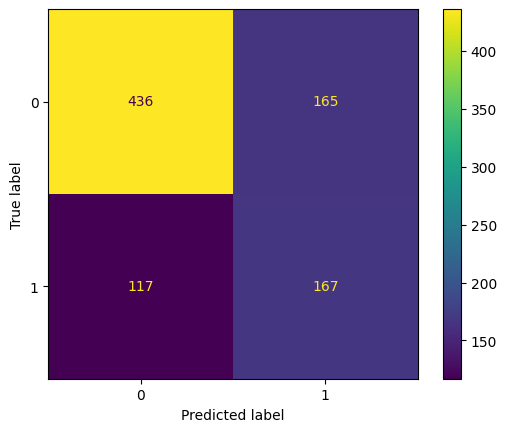

In [78]:
tree_clf.evaluate(X_test, y_test)

### Random Forest

In [79]:
rf_clf = Model(model_name = "Random forest classifier", 
                    estimator = RandomForestClassifier(),
                    preprocessor = preprocess_pipe,
                    scoring = "recall",
                    random_state = 32)

In [80]:
rf_clf.train(X_train, y_train)

Cross validated training results for Random forest classifier model
---------------------------------------------------------
Train score: 1.0 +/- 0.0
Validation score: 0.4406561558080223 +/- 0.03198179966400728


In [81]:
param_grid = {"model__n_estimators": [50, 100, 150, 200],
                "model__max_depth": [2, 10, 15, 20, 25],
                "model__min_samples_split":[2, 3, 4, 5],
                "model__min_samples_leaf": [1, 2, 3, 4, 5]}

rf_clf.tune(param_grid, X_train, y_train)

Best parameters:  {'model__max_depth': 25, 'model__min_samples_leaf': 1, 'model__min_samples_split': 4, 'model__n_estimators': 50}
-------------------Best model performance --------------------------
Score of the model on the train set:
0.909 +/- 0.004060
Score of the model on the validation set:
0.457 +/- 0.032656


Recall score on test set:  0.4295774647887324
Accuracy score on test set:  0.7197740112994351

              precision    recall  f1-score   support

           0       0.76      0.86      0.81       601
           1       0.59      0.43      0.50       284

    accuracy                           0.72       885
   macro avg       0.67      0.64      0.65       885
weighted avg       0.70      0.72      0.71       885



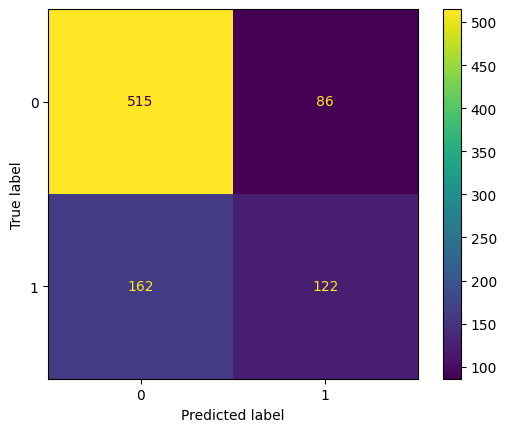

In [82]:
rf_clf.evaluate(X_test, y_test)

### Gradient boosting

In [83]:
gboost_clf = Model(model_name = "Gradient boosting classifier", 
                    estimator = GradientBoostingClassifier(),
                    preprocessor = preprocess_pipe,
                    scoring = "recall",
                    random_state = 32)

In [84]:
gboost_clf.train(X_train, y_train)

Cross validated training results for Gradient boosting classifier model
---------------------------------------------------------
Train score: 0.5488139363386889 +/- 0.006748345269964503
Validation score: 0.47322436046062294 +/- 0.031021825874502806


In [85]:
param_grid = {"model__n_estimators": [100, 200, 300, 400, 450, 500, 550]}

gboost_clf.tune(param_grid, X_train, y_train)

Best parameters:  {'model__n_estimators': 500}
-------------------Best model performance --------------------------
Score of the model on the train set:
0.729 +/- 0.007710
Score of the model on the validation set:
0.504 +/- 0.032392


Recall score on test set:  0.4612676056338028
Accuracy score on test set:  0.7254237288135593

              precision    recall  f1-score   support

           0       0.77      0.85      0.81       601
           1       0.59      0.46      0.52       284

    accuracy                           0.73       885
   macro avg       0.68      0.66      0.66       885
weighted avg       0.71      0.73      0.72       885



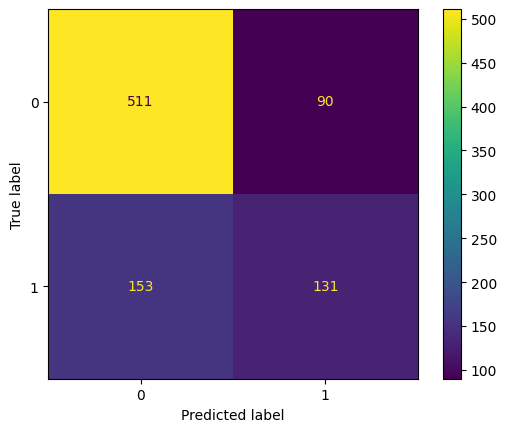

In [86]:
gboost_clf.evaluate(X_test, y_test)

### XGBoost

In [87]:
xgb_clf = Model(model_name = "XGBoost classifier", 
                estimator = XGBClassifier(),
                preprocessor = preprocess_pipe,
                scoring = "recall",
                random_state = 32)

In [88]:
xgb_clf.train(X_train, y_train)

Cross validated training results for XGBoost classifier model
---------------------------------------------------------
Train score: 0.8924754893071725 +/- 0.012486837535573619
Validation score: 0.49342298477471214 +/- 0.025001297842658154


In [89]:
param_grid = {"model__n_estimators": [100, 200, 300, 400, 500],
                "model__max_depth": [5, 10, 15, 20]}

xgb_clf.tune(param_grid, X_train, y_train)

Best parameters:  {'model__max_depth': 5, 'model__n_estimators': 200}
-------------------Best model performance --------------------------
Score of the model on the train set:
0.937 +/- 0.007813
Score of the model on the validation set:
0.514 +/- 0.019170


Recall score on test set:  0.4859154929577465
Accuracy score on test set:  0.7129943502824859

              precision    recall  f1-score   support

           0       0.77      0.82      0.80       601
           1       0.56      0.49      0.52       284

    accuracy                           0.71       885
   macro avg       0.67      0.65      0.66       885
weighted avg       0.70      0.71      0.71       885



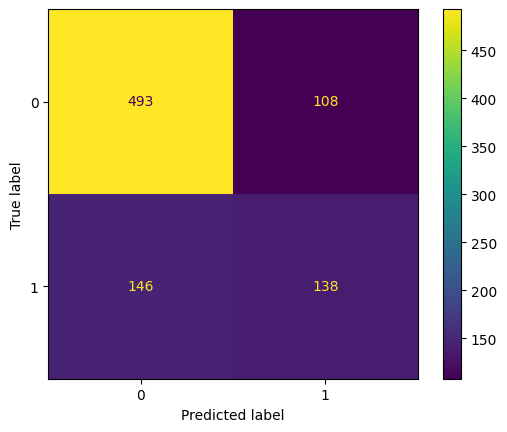

In [90]:
xgb_clf.evaluate(X_test, y_test)

## A closer look at decision tree model

In [91]:
dtree = tree_clf.fitted_model

In [92]:
from sklearn.tree import plot_tree

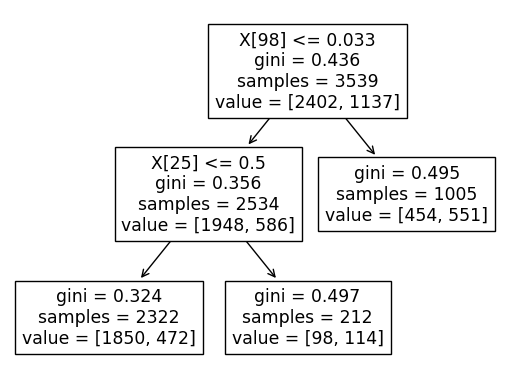

In [93]:
plot_tree(dtree[-1]);

## Using SMOTE to oversample the minority class

In [95]:
cat_mask = [True if x in cat_features else False for x in X_train.columns]
smote = SMOTENC(categorical_features=cat_mask, random_state=32)

### Decision Tree

In [96]:
tree_os_clf = Model(model_name = "Decision tree classifier", 
                    estimator = DecisionTreeClassifier(),
                    preprocessor = preprocess_pipe,
                    sampler = smote,
                    scoring = "recall",
                    random_state = 32)

In [97]:
tree_os_clf.train(X_train, y_train)

Cross validated training results for Decision tree classifier model
---------------------------------------------------------
Train score: 1.0 +/- 0.0
Validation score: 0.5224824174974881 +/- 0.04712507099169669


Recall score on test set:  0.5
Accuracy score on test set:  0.6271186440677966

              precision    recall  f1-score   support

           0       0.74      0.69      0.71       601
           1       0.43      0.50      0.46       284

    accuracy                           0.63       885
   macro avg       0.59      0.59      0.59       885
weighted avg       0.64      0.63      0.63       885



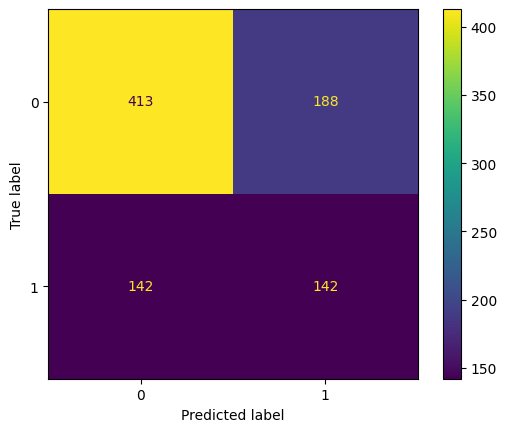

In [98]:
tree_os_clf.evaluate(X_test, y_test)

In [100]:
param_grid = {"model__max_depth": [2, 3, 4, 5, 6, 7, 8],
                "model__min_samples_split":[2, 4, 6, 8, 10],
                "model__min_samples_leaf": [1, 2, 3, 4, 5, 6]}

tree_os_clf.tune(param_grid, X_train, y_train)

Best parameters:  {'model__max_depth': 3, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2}
-------------------Best model performance --------------------------
Score of the model on the train set:
0.866 +/- 0.015751
Score of the model on the validation set:
0.857 +/- 0.027747


Recall score on test set:  0.8838028169014085
Accuracy score on test set:  0.559322033898305

              precision    recall  f1-score   support

           0       0.88      0.41      0.56       601
           1       0.41      0.88      0.56       284

    accuracy                           0.56       885
   macro avg       0.65      0.64      0.56       885
weighted avg       0.73      0.56      0.56       885



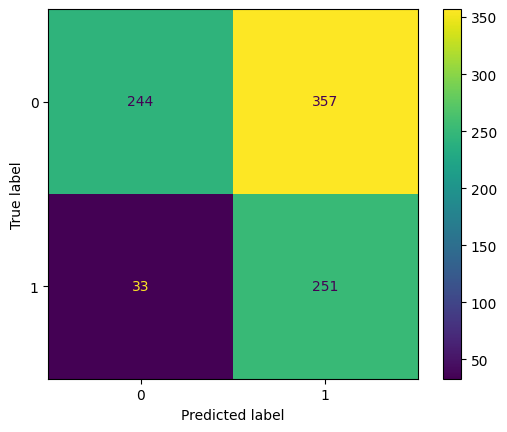

In [101]:
tree_os_clf.evaluate(X_test, y_test)

### Logistic Regression

In [102]:
logreg_os_clf = Model(model_name = "Logistic regression (over sampled) classifier", 
                    estimator = LogisticRegression(penalty = "elasticnet", solver="saga", l1_ratio=0,  max_iter=1000),
                    preprocessor = preprocess_pipe,
                    sampler = smote,
                    scoring = "recall",
                    random_state = 32)

In [103]:
logreg_os_clf.train(X_train, y_train)

Cross validated training results for Logistic regression (over sampled) classifier model
---------------------------------------------------------
Train score: 0.7097663172910698 +/- 0.008500596988626484
Validation score: 0.6746039106577015 +/- 0.02241542328596101


In [104]:
param_grid = {"model__C": [0.01, 0.1, 1, 10, 100],
            "model__l1_ratio": np.linspace(0, 1, 11)}
logreg_os_clf.tune(param_grid, X_train, y_train)

Best parameters:  {'model__C': 0.01, 'model__l1_ratio': 0.2}
-------------------Best model performance --------------------------
Score of the model on the train set:
0.719 +/- 0.009057
Score of the model on the validation set:
0.712 +/- 0.026420


Recall score on test set:  0.7429577464788732
Accuracy score on test set:  0.6892655367231638

              precision    recall  f1-score   support

           0       0.85      0.66      0.74       601
           1       0.51      0.74      0.61       284

    accuracy                           0.69       885
   macro avg       0.68      0.70      0.67       885
weighted avg       0.74      0.69      0.70       885



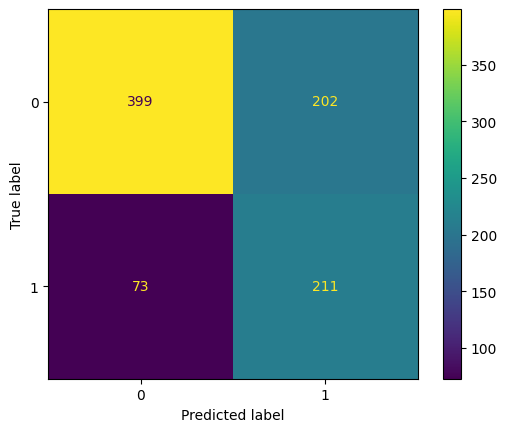

In [105]:
logreg_os_clf.evaluate(X_test, y_test)

### Support vector machine

In [117]:
svm_clf = Model(model_name = "SVM classifier", 
                    estimator = LinearSVC(loss='hinge'),
                    preprocessor = preprocess_pipe,
                    sampler = smote,
                    scoring = "recall",
                    random_state = 32)

In [118]:
svm_clf.train(X_train, y_train)

Cross validated training results for SVM classifier model
---------------------------------------------------------
Train score: 0.7185572842998587 +/- 0.007842505486725066
Validation score: 0.6886621840945978 +/- 0.02827534622202618


In [121]:
param_grid = {"model__penalty": ["l1", "l2"],
                "model__C": [0.001, 0.005, 0.01, 0.1, 1, 10, 100]}
svm_clf.tune(param_grid, X_train, y_train)

Best parameters:  {'model__C': 0.005, 'model__penalty': 'l2'}
-------------------Best model performance --------------------------
Score of the model on the train set:
0.724 +/- 0.015101
Score of the model on the validation set:
0.709 +/- 0.023996


Recall score on test set:  0.7183098591549296
Accuracy score on test set:  0.6926553672316385

              precision    recall  f1-score   support

           0       0.84      0.68      0.75       601
           1       0.52      0.72      0.60       284

    accuracy                           0.69       885
   macro avg       0.68      0.70      0.68       885
weighted avg       0.73      0.69      0.70       885



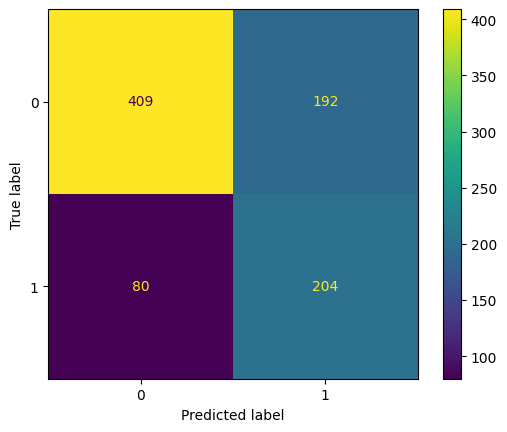

In [122]:
svm_clf.evaluate(X_test, y_test)

### Random Forest

In [106]:
rf_os_clf = Model(model_name = "Random Forest (over sampled) classifier", 
                    estimator = RandomForestClassifier(),
                    preprocessor = preprocess_pipe,
                    sampler = smote,
                    scoring = "recall",
                    random_state = 32)

In [107]:
rf_os_clf.train(X_train, y_train)

Cross validated training results for Random Forest (over sampled) classifier model
---------------------------------------------------------
Train score: 1.0 +/- 0.0
Validation score: 0.578761882680269 +/- 0.033942157221354845


In [109]:
param_grid = {"model__n_estimators": [100, 200, 300, 400]}

rf_os_clf.tune(param_grid, X_train, y_train)

Best parameters:  {'model__n_estimators': 300}
-------------------Best model performance --------------------------
Score of the model on the train set:
1.000 +/- 0.000000
Score of the model on the validation set:
0.609 +/- 0.039045


Recall score on test set:  0.5880281690140845
Accuracy score on test set:  0.7073446327683616

              precision    recall  f1-score   support

           0       0.80      0.76      0.78       601
           1       0.54      0.59      0.56       284

    accuracy                           0.71       885
   macro avg       0.67      0.68      0.67       885
weighted avg       0.71      0.71      0.71       885



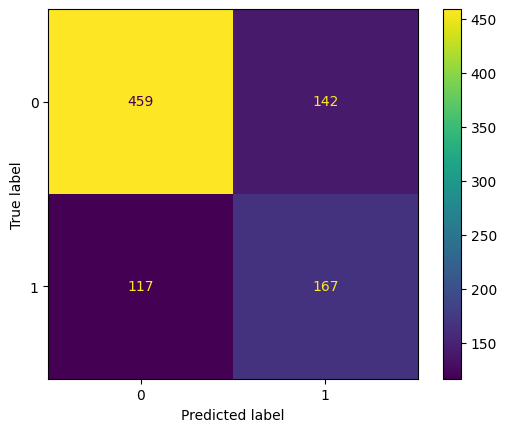

In [110]:
rf_os_clf.evaluate(X_test, y_test)

### Xgboost

In [111]:
xgb_os_clf = Model(model_name = "XGBoost classifier", 
                estimator = XGBClassifier(),
                preprocessor = preprocess_pipe,
                sampler = smote,
                scoring = "recall",
                random_state = 32)

In [112]:
xgb_os_clf.train(X_train, y_train)

Cross validated training results for XGBoost classifier model
---------------------------------------------------------
Train score: 0.9278772712436079 +/- 0.0074107620972285486
Validation score: 0.5708014529716362 +/- 0.013135422397821478


In [113]:
param_grid = {"model__n_estimators": [100, 200, 300, 400, 500]}

xgb_os_clf.tune(param_grid, X_train, y_train)

Best parameters:  {'model__n_estimators': 100}
-------------------Best model performance --------------------------
Score of the model on the train set:
0.928 +/- 0.007411
Score of the model on the validation set:
0.571 +/- 0.013135


Recall score on test set:  0.5669014084507042
Accuracy score on test set:  0.6994350282485876

              precision    recall  f1-score   support

           0       0.79      0.76      0.77       601
           1       0.53      0.57      0.55       284

    accuracy                           0.70       885
   macro avg       0.66      0.66      0.66       885
weighted avg       0.71      0.70      0.70       885



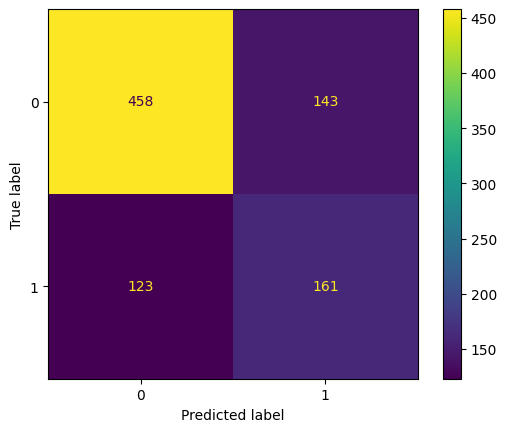

In [114]:
xgb_os_clf.evaluate(X_test, y_test)

## Best model - Logistic regression with SMOTE

In [ ]:
logreg_os_clf = Model(model_name = "Logistic regression (over sampled) classifier", 
                    estimator = LogisticRegression(penalty="elasticnet", C=0.1, solver="saga", l1_ratio=0.9,  max_iter=1000),
                    preprocessor = preprocess_pipe,
                    sampler = smote,
                    scoring = "recall",
                    random_state = 32)

In [ ]:
logreg_os_clf.train(X_train, y_train)

Cross validated training results for Logistic regression (over sampled) classifier model
---------------------------------------------------------
Train score: 0.7029485366119029 +/- 0.004434476189028254
Validation score: 0.6965955637993663 +/- 0.019234016648345738


Recall score on test set:  0.7288732394366197
Accuracy score on test set:  0.6734463276836158

              precision    recall  f1-score   support

           0       0.83      0.65      0.73       601
           1       0.49      0.73      0.59       284

    accuracy                           0.67       885
   macro avg       0.66      0.69      0.66       885
weighted avg       0.73      0.67      0.68       885



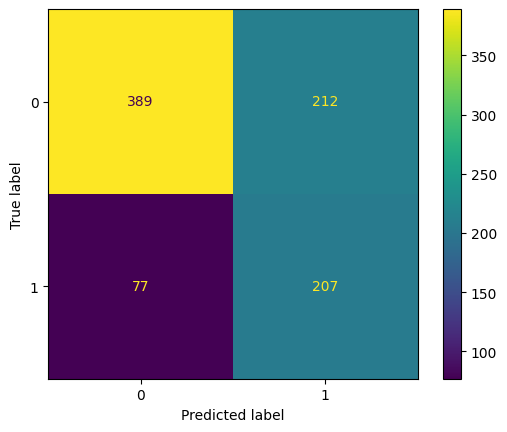

In [ ]:
logreg_os_clf.evaluate(X_test, y_test)

### Feature importance

In [ ]:
coefs = logreg_os_clf.fitted_model[-1].coef_

In [ ]:
features = cat_features + num_features

importance_df = pd.DataFrame()
importance_df['Feature'] = features
importance_df['Importance'] = np.abs(np.exp(coefs.reshape(-1))) * X_train.std()
importance_df['Relative Importance'] = importance_df['Importance'] / importance_df['Importance'].sum()


importance_df.sort_values(by='Importance', ascending=False, inplace=True)

ValueError: operands could not be broadcast together with shapes (18,) (14,) 

In [ ]:
X_train.std()

Marital status                       0.597108
Application mode                    17.487095
Application order                    1.307274
Course                            2081.250633
Previous qualification (grade)      13.202248
Admission grade                     14.530706
Displaced                            0.497689
Educational special needs            0.107024
Debtor                               0.312832
Tuition fees up to date              0.323121
Gender                               0.477245
Scholarship holder                   0.434573
Age at enrollment                    7.605164
International                        0.154003
dtype: float64

Text(0.5, 1.0, 'Logistic Regression model - Feature Importance')

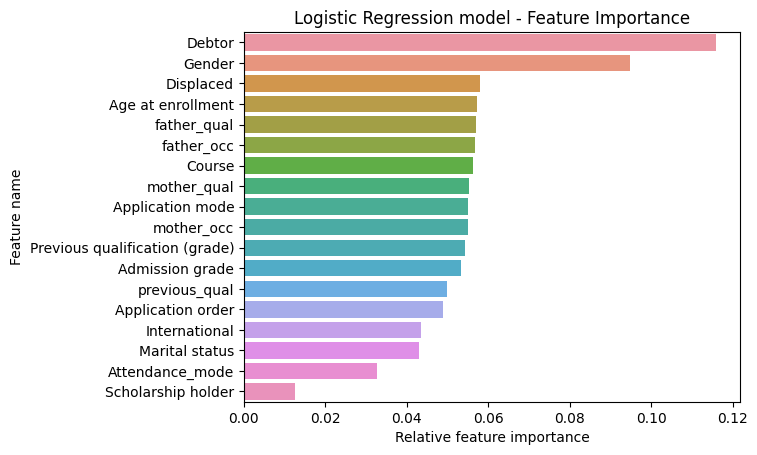

In [ ]:
sns.barplot(data=importance_df, y = 'Feature', x = 'Relative Importance')
plt.xlabel("Relative feature importance")
plt.ylabel("Feature name")
plt.title("Logistic Regression model - Feature Importance")

In [ ]:
importance_df

,Feature,Importance,Relative Importance
2,Debtor,2.139092,0.115996
3,Gender,1.750096,0.094902
13,Displaced,1.069270,0.057983
16,Age at enrollment,1.057201,0.057329
7,father_qual,1.052682,0.057084
5,father_occ,1.044721,0.056652
0,Course,1.038021,0.056289
8,mother_qual,1.019985,0.055311
10,Application mode,1.015743,0.055080
6,mother_occ,1.015711,0.055079
